In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
try:
    df = pd.read_csv('fruit.csv')
    X = df[['length_cm', 'weight_g', 'yellow_score']].values
    y = df['label'].values.reshape(-1, 1)
except FileNotFoundError:
    print("Error: fruit.csv not found.")
    exit()

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total samples: 98
Training samples: 78
Testing samples: 20


In [7]:
# Calculate scaling factors from training data ONLY
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

# Scale both training and test data
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

# Add bias term
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

print("\nFirst 5 rows of processed training data:")
print(X_train_b[:5])


First 5 rows of processed training data:
[[ 1.         -1.02291091  0.36559923 -0.56720518]
 [ 1.          1.56521442 -1.07779253  0.77767755]
 [ 1.          1.10016065 -1.11680311  0.82405281]
 [ 1.          1.01928173 -0.92175017  0.73130228]
 [ 1.          1.36301713 -0.80471841  0.87042808]]


In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Hyperparameters
learning_rate = 0.1
epochs = 500 # Train for the full 500 epochs as required
n_samples = len(y_train)

# Initialize weights
np.random.seed(42)
weights = np.random.randn(X_train_b.shape[1], 1)

# Lists for storing history
losses = []
accuracies = []

In [9]:
print("--- Starting Model Training for 500 Epochs ---")
for epoch in range(epochs):
    # Forward pass on training data
    predictions = sigmoid(X_train_b @ weights)

    # Calculate loss and accuracy on training data
    loss = -np.mean(y_train * np.log(predictions) + (1 - y_train) * np.log(1 - predictions))
    accuracy = np.mean((predictions > 0.5).astype(int) == y_train)
    losses.append(loss)
    accuracies.append(accuracy)

    # Backward pass: Calculate gradient
    gradient = (1 / n_samples) * X_train_b.T @ (predictions - y_train)

    # Update weights
    weights -= learning_rate * gradient

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.2%}")

print("\n--- Training Complete ---")

--- Starting Model Training for 500 Epochs ---
Epoch 0, Training Loss: 0.4903, Training Accuracy: 79.49%
Epoch 50, Training Loss: 0.0922, Training Accuracy: 100.00%
Epoch 100, Training Loss: 0.0496, Training Accuracy: 100.00%
Epoch 150, Training Loss: 0.0340, Training Accuracy: 100.00%
Epoch 200, Training Loss: 0.0260, Training Accuracy: 100.00%
Epoch 250, Training Loss: 0.0211, Training Accuracy: 100.00%
Epoch 300, Training Loss: 0.0178, Training Accuracy: 100.00%
Epoch 350, Training Loss: 0.0154, Training Accuracy: 100.00%
Epoch 400, Training Loss: 0.0136, Training Accuracy: 100.00%
Epoch 450, Training Loss: 0.0121, Training Accuracy: 100.00%
Epoch 499, Training Loss: 0.0110, Training Accuracy: 100.00%

--- Training Complete ---


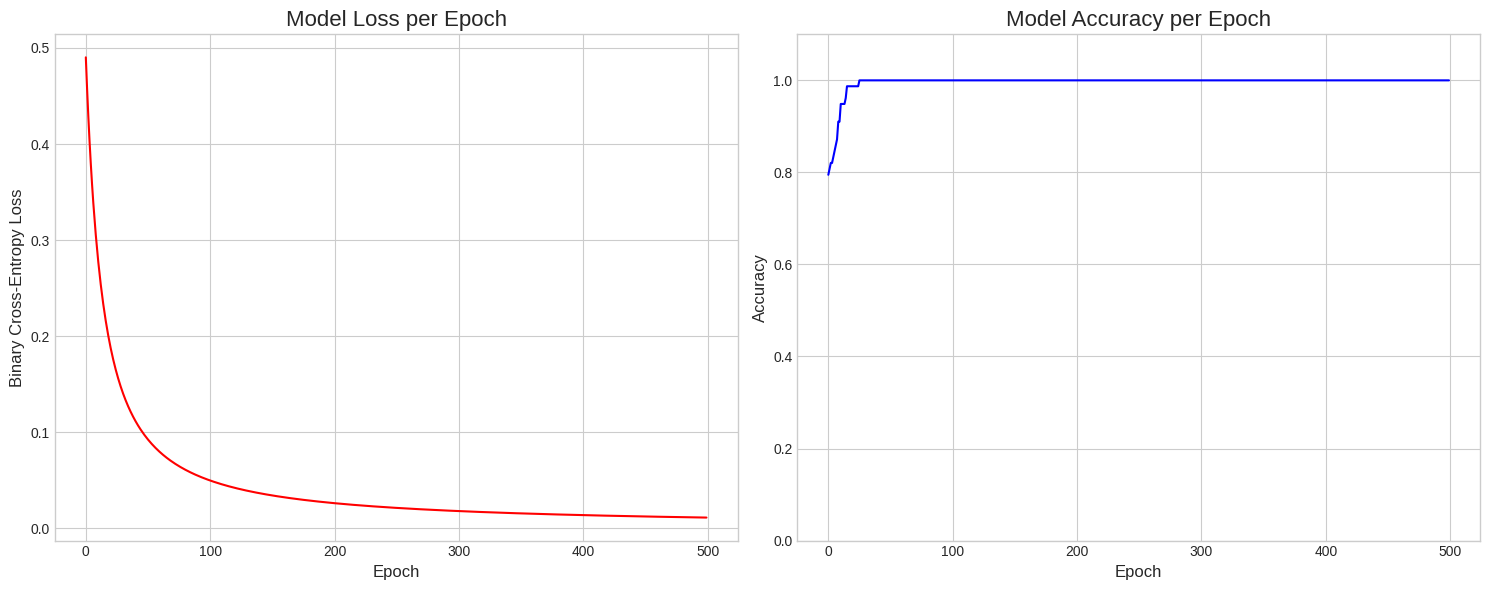

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# Plot Loss
ax1.plot(range(len(losses)), losses, color='red')
ax1.set_title('Model Loss per Epoch', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Binary Cross-Entropy Loss', fontsize=12)
# Plot Accuracy
ax2.plot(range(len(accuracies)), accuracies, color='blue')
ax2.set_title('Model Accuracy per Epoch', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [11]:
print("\\n--- Evaluating on Unseen Test Data ---")
test_predictions = sigmoid(X_test_b @ weights)
predicted_labels = (test_predictions > 0.5).astype(int)

# Calculate final test accuracy
test_accuracy = np.mean(predicted_labels == y_test)

print(f"\\nFINAL TEST ACCURACY: {test_accuracy:.2%}")

\n--- Evaluating on Unseen Test Data ---
\nFINAL TEST ACCURACY: 100.00%


In [13]:
print("\\n--- Final Model Weights ---")
feature_names = ["Bias", "Length (cm)", "Weight (g)", "Yellow Score"]
for name, weight_value in zip(feature_names, weights.flatten()):
    print(f"{name}: {weight_value:.4f}")

def predict_fruit(features, mean, std, model_weights):
    scaled_features = (features - mean) / std
    features_with_bias = np.insert(scaled_features, 0, 1)
    probability = sigmoid(features_with_bias @ model_weights)[0]
    return ("Banana", probability) if probability >= 0.5 else ("Apple", probability)

print("\\n--- Predict on a New Fruit ---")
my_fruit = np.array([17.0, 140, 0.01]) # A long, light, very yellow fruit
prediction, confidence = predict_fruit(my_fruit, train_mean, train_std, weights)
print(f"Predicting for: [length: {my_fruit[0]}, weight: {my_fruit[1]}, yellow: {my_fruit[2]}]")
print(f"--> Prediction: '{prediction}' with {confidence:.2%} confidence.") 

\n--- Final Model Weights ---
Bias: -0.1678
Length (cm): 1.7302
Weight (g): -1.0199
Yellow Score: 2.7615
\n--- Predict on a New Fruit ---
Predicting for: [length: 17.0, weight: 140.0, yellow: 0.01]
--> Prediction: 'Apple' with 0.10% confidence.


In [14]:
np.savetxt("model_weights.csv", weights, delimiter=",")

print("--- Weights Saved ---")
print("The final weights have been saved to 'model_weights.csv'.")
print("You can now find this file in the file explorer and download it.") 

--- Weights Saved ---
The final weights have been saved to 'model_weights.csv'.
You can now find this file in the file explorer and download it.
